# Using FastAI from scratch

#First, let's import our dataset from kaggle

!pip install kaggle

project = 'titanic'

from pathlib import Path
import os

api_token = {"username":"username","key":"api-key"}

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('../input/' + project)
    !pip install -Uqq fastai
else:
    import zipfile,kaggle
    path = Path(project)
    if not path.exists():
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [16]:
from fastai.tabular.all import *

pd.options.display.float_format = '{:.2f}'.format
set_seed(42)

In [2]:
df = pd.read_csv('titanic' + '/train.csv')

<AxesSubplot:>

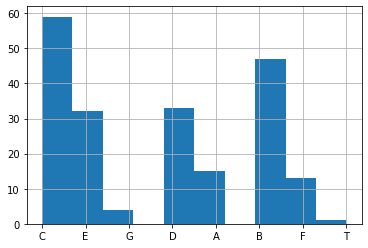

In [3]:
df.Cabin.str[0].hist()

In [4]:
df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')

In [5]:
df[['Ticket','TicketFreq']].sort_values(by='Ticket')

,Ticket,TicketFreq
504,110152,3
257,110152,3
759,110152,3
262,110413,3
558,110413,3
...,...,...
235,W./C. 6609,1
92,W.E.P. 5734,1
219,W/C 14208,1
540,WE/P 5735,2


In [6]:
def add_features(df):
    df['LogFare'] = np.log1p(df['Fare'])
    df['Family'] = df.SibSp+df.Parch
    df['Deck'] = df.Cabin.str[0].map(dict(A="ABC", B="ABC", C="ABC", D="DE", E="DE", F="FG", G="FG"))
    df['Alone'] = df.Family==0
    df['TicketFreq'] = df.groupby('Ticket')['Ticket'].transform('count')
    df['Title'] = df.Name.str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    df['Title'] = df.Title.map(dict(Mr="Mr",Miss="Miss",Mrs="Mrs",Master="Master"))

add_features(df)

In [7]:
splits = RandomSplitter(seed=42)(df)

In [9]:
dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=["Sex","Pclass","Embarked","Deck", "Title"],
    cont_names=['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family'],
    y_names="Survived", y_block = CategoryBlock()
).dataloaders(path=".")

In [12]:
cat_names = ["Sex","Pclass","Embarked","Deck", "Title"]
cont_names = ['Age', 'SibSp', 'Parch', 'LogFare', 'Alone', 'TicketFreq', 'Family']
y_names = 'Survived'


dls = TabularPandas(
    df, splits=splits,
    procs = [Categorify, FillMissing, Normalize],
    cat_names=cat_names,
    cont_names=cont_names,
    y_names = y_names,
    y_block = CategoryBlock()
).dataloaders(path=".")

In [18]:
learn = tabular_learner(dls, 
                         metrics=accuracy,
                         layers=[10,10])

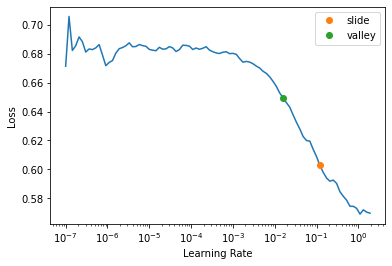

In [32]:
s, v = learn.lr_find(suggest_funcs=(slide,valley));
lr = ((v - s)/2) + s

In [33]:
learn.fit(16, lr=lr)

epoch,train_loss,valid_loss,accuracy,time
0,0.602451,0.473853,0.792135,00:00
1,0.518857,0.477447,0.786517,00:00
2,0.482538,0.460539,0.825843,00:00
3,0.450875,0.450034,0.820225,00:00
4,0.433916,0.429124,0.831461,00:00
5,0.423935,0.428268,0.825843,00:00
6,0.416861,0.453822,0.825843,00:00
7,0.414691,0.426295,0.825843,00:00
8,0.405863,0.428234,0.814607,00:00
9,0.401799,0.429181,0.820225,00:00


In [35]:
tst_df = pd.read_csv('titanic' + '/test.csv')
tst_df['Fare'] = tst_df.Fare.fillna(0)
add_features(tst_df)

tst_dl = learn.dls.test_dl(tst_df)

preds,_ = learn.get_preds(dl=tst_dl)

tst_df['Survived'] = (preds[:,1]>0.5).int()
sub_df = tst_df[['PassengerId','Survived']]
sub_df.to_csv('sub.csv', index=False)